In [1]:
import torch
import torch.nn as nn
import numpy as np
import time
import math
from matplotlib import pyplot
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import date
from sklearn.preprocessing import LabelEncoder
torch.manual_seed(0)
np.random.seed(0)
# This concept is also called teacher forceing.
# The flag decides if the loss will be calculted over all or just the predicted values.
calculate_loss_over_all_values = False

input_window = 100
output_window = 1
batch_size = 256      # batch size
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# device = ("cpu")


cuda


In [2]:
# class PositionalEncoding(nn.Module):

#     def __init__(self, d_model, max_len=5000):
#         super(PositionalEncoding, self).__init__()
#         pe = torch.zeros(max_len, d_model)
#         position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)
#         pe = pe.unsqueeze(0).transpose(0, 1)

#         # pe.requires_grad = False
#         self.register_buffer('pe', pe)

#     def forward(self, x):
#         return x + self.pe[:x.size(0), :]
    
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=20000):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        # div_term = torch.exp(
        #     torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        # )
        div_term = 1 / (10000 ** ((2 * np.arange(d_model)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term[0::2])
        pe[:, 1::2] = torch.cos(position * div_term[1::2])

        pe = pe.unsqueeze(0).transpose(0, 1) # [5000, 1, d_model],so need seq-len <= 5000
        #pe.requires_grad = False
        self.register_buffer('pe', pe)

    def forward(self, x):
        # print(self.pe[:x.size(0), :].repeat(1,x.shape[1],1).shape ,'---',x.shape)
        # dimension 1 maybe inequal batchsize
        return x + self.pe[:x.size(0), :].repeat(1,x.shape[1],1)

In [3]:
class TransAm(nn.Module):
    def __init__(self, feature_size=5, num_layers=1, dropout=0.1):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'

        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=5, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(feature_size, feature_size)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device

            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        # print('j',src.size(),self.src_mask.size())
        output = self.transformer_encoder(src, self.src_mask)  # , self.src_mask)
        output = self.decoder(output)

        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask
    
    

In [4]:
# if window is 100 and prediction step is 1
# in -> [0..99]
# target -> [1..100]
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    # print(L)
    # np.zeros((output_window, 3))
    for i in range(L-tw):
        train_seq = np.append(input_data[i:i+tw, :][:-output_window, :], np.zeros((output_window,5)), axis=0)
        # train_label = input_data[i+output_window:i+tw+output_window,:]
        train_label = input_data[i:i+tw, :]
        # train_label = input_data[i+output_window:i+tw+output_window]
        # print("train_seq.shape, train_label.shape:", train_seq.shape, train_label.shape)    # (96, 8), (96, 8)
        inout_seq.append((train_seq, train_label))
    return torch.FloatTensor(inout_seq)

In [5]:
def get_data():
    # time        = np.arange(0, 400, 0.1)
    # amplitude   = np.sin(time) + np.sin(time*0.05) +np.sin(time*0.12) *np.random.normal(-0.2, 0.2, len(time))
    # series = read_csv('daily-min-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)

    from sklearn.preprocessing import MinMaxScaler
    from sklearn.preprocessing import LabelEncoder
    scaler = MinMaxScaler(feature_range=(-1, 1))

    check_data = pd.read_csv('180801_RFB_510cy_006_DC_20000.csv')
    check_data.set_index('전압(V)', inplace=True)
    values = check_data.values
    encoder = LabelEncoder()
    values[:, 4] = encoder.fit_transform(values[:, 4])
    dataset = pd.DataFrame(values)
    data = dataset[:]

    # data = pd.read_csv('processed.csv')
    # dataset = data.loc[:, "pm2.5":  "SE"]
    series = data.to_numpy()
    amplitude = scaler.fit_transform(series)
    # amplitude = scaler.fit_transform(amplitude.reshape(-1, 1)).reshape(-1)

    sampels = int(len(data) * 0.7)
    train_data = amplitude[:sampels]
    test_data = amplitude[sampels:]

    train_sequence = create_inout_sequences(train_data, input_window)
    train_sequence = train_sequence[:-output_window]

    # test_data = torch.FloatTensor(test_data).view(-1)
    test_data = create_inout_sequences(test_data, input_window)
    test_data = test_data[:-output_window]

    return train_sequence.to(device), test_data.to(device), scaler

In [6]:
def get_batch(source, i, batch_size):
    seq_len = min(batch_size, len(source)-1-i)
    data = source[i:i+seq_len]
    input = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window, 1)).squeeze()  # 1 is feature size
    target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window, 1)).squeeze()
    return input, target

In [7]:
def train(train_data):
    model.train()  # Turn on the train mode
    total_loss = 0.
    start_time = time.time()

    for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):
        data, targets = get_batch(train_data, i, batch_size)
        optimizer.zero_grad()
        output = model(data)

        if calculate_loss_over_all_values:
            loss = criterion(output, targets)
        else:
            loss = criterion(output[-output_window:], targets[-output_window:])

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        log_interval = int(len(train_data) / batch_size / 5)
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | ''lr {:02.6f} | {:5.2f} ms | '
                  'loss {:5.5f} | ppl {:8.2f}'.format(epoch, batch, len(train_data) // batch_size,
                                                      scheduler.get_lr()[0],
                                                      elapsed * 1000 / log_interval, cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

In [8]:
def plot(eval_model, data_source, epoch, scaler):
    eval_model.eval()
    total_loss = 0.
    test_result = torch.Tensor(0)
    truth = torch.Tensor(0)
    with torch.no_grad():
        for i in range(0, len(data_source)-1):
            data, target = get_batch(data_source, i, 1)
            data = data.unsqueeze(1)
            target = target.unsqueeze(1)
            output = eval_model(data)
            if calculate_loss_over_all_values:
                total_loss += criterion(output, target).item()
            else:
                total_loss += criterion(output[-output_window:], target[-output_window:]).item()

            test_result = torch.cat((test_result, output[-1, :].squeeze(1).cpu()), 0)
            truth = torch.cat((truth, target[-1, :].squeeze(1).cpu()), 0)

    # test_result = test_result.cpu().numpy()
    # len(test_result)

    test_result_ = scaler.inverse_transform(test_result[:800])
    truth_ = scaler.inverse_transform(truth[:800])
    print("test_result.shape, truth.shape:", test_result.shape, truth.shape)

    rmse = np.sqrt(mean_squared_error(truth, test_result))
    mae = mean_absolute_error(truth, test_result)
    # mape = mean_absolute_percentage_error(truth, test_result)
    print('Test RMSE: %.3f' % rmse)
    print('Test MAE: %.3f' % mae)
    # print('Test MAPE: %.3f' % mape)

    # pyplot.rcParams['font.family'] = 'serif'
    # pyplot.rcParams['font.serif'] = ['Times New Roman'] + pyplot.rcParams['font.serif']
    dates = ['07-04', '07-07', '07-10', '07-13', '07-16', '07-19']
    pyplot.plot(test_result_[71:430, 0], label='prediction')  # [17:376]   71:430
    pyplot.plot(truth_[71:430, 0], label='ground_truth')
    pyplot.title("Prediction vs. Actual Value of PM2.5", fontsize='16')
    pyplot.xlabel('Time', fontsize='14')
    pyplot.ylabel('PM2.5', fontsize='14')
    pyplot.legend(prop={"size": 14})
    pyplot.xticks(np.arange(0, 361, 72), dates, fontsize=12)
    pyplot.yticks(fontsize=12)
    
    # pyplot.plot(test_result_[73:432, 0], label='prediction')  # [17:376]
    # pyplot.plot(truth_[73:432, 0], label='ground_truth')
    # pyplot.title("Prediction V.S. actual value of PM2.5", fontsize='16')
    # pyplot.xlabel('Timestamp', fontsize='14')
    # pyplot.ylabel('PM2.5', fontsize='14')
    # pyplot.legend(prop={"size": 12})
    # pyplot.xticks(fontsize=14)
    # pyplot.yticks(fontsize=14)
    # pyplot.savefig('graph/lstm_prediction.png', dpi=300)

    # pyplot.plot(test_result - truth, color="green")
    # pyplot.grid(True, which='both')
    # pyplot.axhline(y=0, color='k')
    # pyplot.savefig('graph/transformer-epoch%d.png' % epoch)
    pyplot.show()
    pyplot.close()

    # for m in range(9):
    # test_result = test_result_[17:735,0]
    # truth = truth_[17:735,0]
    # fig = pyplot.figure(1, figsize=(20, 5))
    # fig.patch.set_facecolor('xkcd:white')
    # # pyplot.plot([k + 510 for k in range(190)], test_result[510:],color="red")
    # pyplot.plot(test_result_[17:376, 0])  # 17: 376 : 759 --> 2013/07/01/00:00 - 2013/07/15/23:00 - 2013/07/31/23:00
    # pyplot.plot(truth_[17:376, 0])
    # pyplot.title('Predicted V.S. Actual Values of PM2.5')
    # pyplot.legend(["prediction", "ground_truth"], loc="upper right")
    # ymin, ymax = pyplot.ylim()
    # # pyplot.vlines(510, ymin, ymax, color="blue", linestyles="dashed", linewidth=2)
    # pyplot.ylim(ymin, ymax)
    # pyplot.xlabel("Timestamp")
    # pyplot.ylabel("PM2.5")
    # pyplot.show()
    # pyplot.close()

    return total_loss / i

In [9]:
# entweder ist hier ein fehler im loss oder in der train methode, aber die ergebnisse sind unterschiedlich
# auch zu denen der predict_future
def evaluate(eval_model, data_source):
    eval_model.eval()  # Turn on the evaluation mode
    total_loss = 0.
    eval_batch_size = 800
    with torch.no_grad():
        for i in range(0, len(data_source) - 1, eval_batch_size):
            data, targets = get_batch(data_source, i, eval_batch_size)
            output = eval_model(data)
            # print(output[-output_window:].size(), targets[-output_window:].size())
            if calculate_loss_over_all_values:
                total_loss += len(data[0]) * criterion(output, targets).cpu().item()
            else:
                total_loss += len(data[0]) * criterion(output[-output_window:], targets[-output_window:]).cpu().item()
    return total_loss / (len(data_source)+1)

C:\Users\user\AppData\Local\Temp\ipykernel_16052\2837444224.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:233.)
  return torch.FloatTensor(inout_seq)
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:381: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch   1 |    10/   54 batches | lr 0.000500 | 139.39 ms | loss 0.74116 | ppl     2.10
| epoch   1 |    20/   54 batches | lr 0.000500 | 10.18 ms | loss 0.48269 | ppl     1.62
| epoch   1 |    30/   54 batches | lr 0.000500 | 10.28 ms | loss 0.40842 | ppl     1.50
| epoch   1 |    40/   54 batches | lr 0.000500 | 10.31 ms | loss 0.38745 | ppl     1.47
| epoch   1 |    50/   54 batches | lr 0.000500 |  9.98 ms | loss 0.39622 | ppl     1.49
-----------------------------------------------------------------------------------------
| end of epoch   1 | time:  2.17s | valid loss 0.50740 | valid ppl     1.66
| end of epoch   1 | time:  2.17s | train loss 0.38685 | train ppl     1.47
-----------------------------------------------------------------------------------------
| epoch   2 |    10/   54 batches | lr 0.000480 | 10.90 ms | loss 0.52557 | ppl     1.69
| epoch   2 |    20/   54 batches | lr 0.000480 |  9.89 ms | loss 0.36739 | ppl     1.44
| epoch   2 |    30/   54 batches | lr 0.000

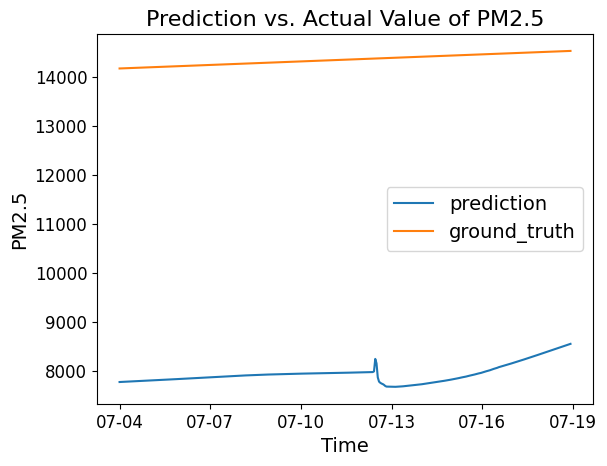

-----------------------------------------------------------------------------------------
| end of epoch  30 | time:  4.56s | valid loss 0.19227 | valid ppl     1.21
| end of epoch  30 | time:  4.56s | train loss 0.05995 | train ppl     1.06
-----------------------------------------------------------------------------------------
| epoch  31 |    10/   54 batches | lr 0.000267 | 11.80 ms | loss 0.15840 | ppl     1.17


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:381: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  31 |    20/   54 batches | lr 0.000267 | 10.72 ms | loss 0.05498 | ppl     1.06
| epoch  31 |    30/   54 batches | lr 0.000267 | 10.87 ms | loss 0.03277 | ppl     1.03
| epoch  31 |    40/   54 batches | lr 0.000267 | 10.62 ms | loss 0.04262 | ppl     1.04
| epoch  31 |    50/   54 batches | lr 0.000267 | 10.07 ms | loss 0.07218 | ppl     1.07
-----------------------------------------------------------------------------------------
| end of epoch  31 | time:  0.87s | valid loss 0.18922 | valid ppl     1.21
| end of epoch  31 | time:  0.87s | train loss 0.05754 | train ppl     1.06
-----------------------------------------------------------------------------------------
| epoch  32 |    10/   54 batches | lr 0.000262 | 11.00 ms | loss 0.15722 | ppl     1.17
| epoch  32 |    20/   54 batches | lr 0.000262 |  9.90 ms | loss 0.05645 | ppl     1.06
| epoch  32 |    30/   54 batches | lr 0.000262 | 10.44 ms | loss 0.03428 | ppl     1.03
| epoch  32 |    40/   54 batches | lr 0.0002

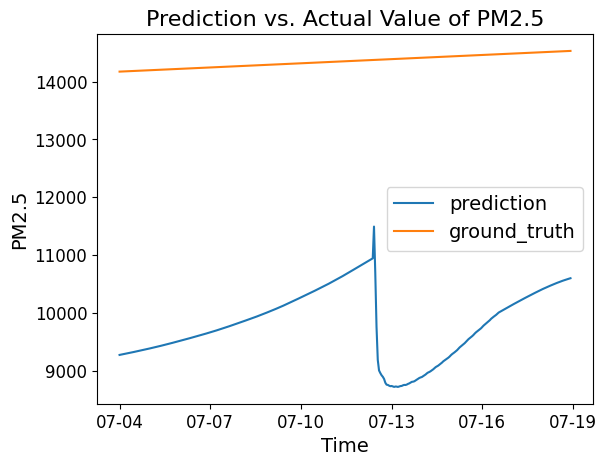

-----------------------------------------------------------------------------------------
| end of epoch  60 | time:  4.45s | valid loss 0.11844 | valid ppl     1.13
| end of epoch  60 | time:  4.45s | train loss 0.03521 | train ppl     1.04
-----------------------------------------------------------------------------------------
| epoch  61 |    10/   54 batches | lr 0.000146 | 11.46 ms | loss 0.11337 | ppl     1.12


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:381: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  61 |    20/   54 batches | lr 0.000146 | 10.10 ms | loss 0.04432 | ppl     1.05
| epoch  61 |    30/   54 batches | lr 0.000146 | 10.07 ms | loss 0.03065 | ppl     1.03
| epoch  61 |    40/   54 batches | lr 0.000146 | 10.19 ms | loss 0.03451 | ppl     1.04
| epoch  61 |    50/   54 batches | lr 0.000146 | 10.24 ms | loss 0.05353 | ppl     1.05
-----------------------------------------------------------------------------------------
| end of epoch  61 | time:  0.85s | valid loss 0.11748 | valid ppl     1.12
| end of epoch  61 | time:  0.85s | train loss 0.03404 | train ppl     1.03
-----------------------------------------------------------------------------------------
| epoch  62 |    10/   54 batches | lr 0.000143 | 11.27 ms | loss 0.10832 | ppl     1.11
| epoch  62 |    20/   54 batches | lr 0.000143 | 10.01 ms | loss 0.04359 | ppl     1.04
| epoch  62 |    30/   54 batches | lr 0.000143 | 10.19 ms | loss 0.03127 | ppl     1.03
| epoch  62 |    40/   54 batches | lr 0.0001

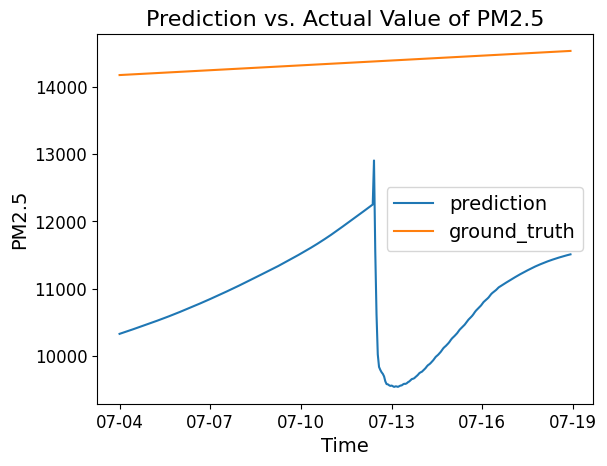

-----------------------------------------------------------------------------------------
| end of epoch  90 | time:  4.49s | valid loss 0.09072 | valid ppl     1.09
| end of epoch  90 | time:  4.49s | train loss 0.02712 | train ppl     1.03
-----------------------------------------------------------------------------------------
| epoch  91 |    10/   54 batches | lr 0.000080 | 11.26 ms | loss 0.09042 | ppl     1.09


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:381: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  91 |    20/   54 batches | lr 0.000080 | 10.40 ms | loss 0.03898 | ppl     1.04
| epoch  91 |    30/   54 batches | lr 0.000080 | 10.02 ms | loss 0.03045 | ppl     1.03
| epoch  91 |    40/   54 batches | lr 0.000080 | 10.15 ms | loss 0.03474 | ppl     1.04
| epoch  91 |    50/   54 batches | lr 0.000080 | 10.20 ms | loss 0.04736 | ppl     1.05
-----------------------------------------------------------------------------------------
| end of epoch  91 | time:  0.85s | valid loss 0.09055 | valid ppl     1.09
| end of epoch  91 | time:  0.85s | train loss 0.02716 | train ppl     1.03
-----------------------------------------------------------------------------------------
| epoch  92 |    10/   54 batches | lr 0.000078 | 11.14 ms | loss 0.09245 | ppl     1.10
| epoch  92 |    20/   54 batches | lr 0.000078 | 10.13 ms | loss 0.03790 | ppl     1.04
| epoch  92 |    30/   54 batches | lr 0.000078 | 10.30 ms | loss 0.02917 | ppl     1.03
| epoch  92 |    40/   54 batches | lr 0.0000

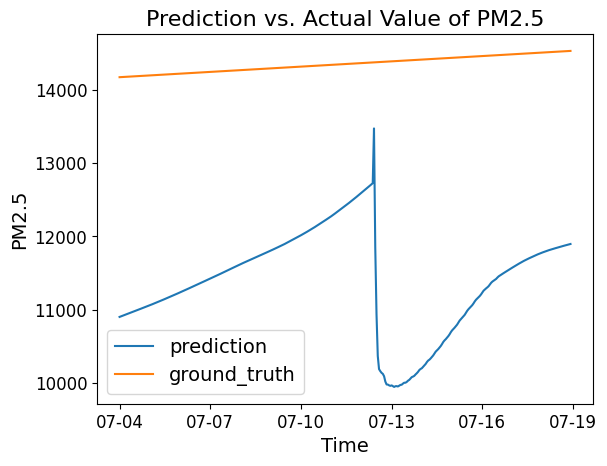

-----------------------------------------------------------------------------------------
| end of epoch 120 | time:  4.49s | valid loss 0.07944 | valid ppl     1.08
| end of epoch 120 | time:  4.49s | train loss 0.02453 | train ppl     1.02
-----------------------------------------------------------------------------------------
| epoch 121 |    10/   54 batches | lr 0.000043 | 11.73 ms | loss 0.08139 | ppl     1.08


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:381: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch 121 |    20/   54 batches | lr 0.000043 | 10.26 ms | loss 0.03512 | ppl     1.04
| epoch 121 |    30/   54 batches | lr 0.000043 | 10.20 ms | loss 0.03013 | ppl     1.03
| epoch 121 |    40/   54 batches | lr 0.000043 | 10.20 ms | loss 0.03200 | ppl     1.03
| epoch 121 |    50/   54 batches | lr 0.000043 | 10.14 ms | loss 0.04112 | ppl     1.04
-----------------------------------------------------------------------------------------
| end of epoch 121 | time:  0.86s | valid loss 0.07943 | valid ppl     1.08
| end of epoch 121 | time:  0.86s | train loss 0.02439 | train ppl     1.02
-----------------------------------------------------------------------------------------
| epoch 122 |    10/   54 batches | lr 0.000043 | 11.00 ms | loss 0.08375 | ppl     1.09
| epoch 122 |    20/   54 batches | lr 0.000043 | 10.25 ms | loss 0.03704 | ppl     1.04
| epoch 122 |    30/   54 batches | lr 0.000043 | 10.06 ms | loss 0.03109 | ppl     1.03
| epoch 122 |    40/   54 batches | lr 0.0000

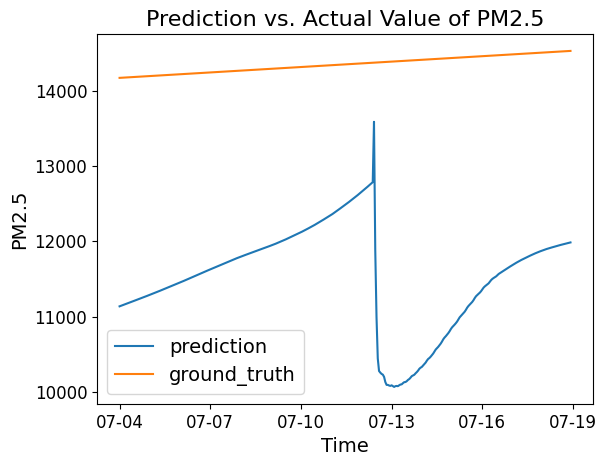

-----------------------------------------------------------------------------------------
| end of epoch 150 | time:  4.48s | valid loss 0.07492 | valid ppl     1.08
| end of epoch 150 | time:  4.48s | train loss 0.02324 | train ppl     1.02
-----------------------------------------------------------------------------------------
| epoch 151 |    10/   54 batches | lr 0.000024 | 11.64 ms | loss 0.08019 | ppl     1.08


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:381: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch 151 |    20/   54 batches | lr 0.000024 | 10.42 ms | loss 0.03289 | ppl     1.03
| epoch 151 |    30/   54 batches | lr 0.000024 | 10.19 ms | loss 0.03088 | ppl     1.03
| epoch 151 |    40/   54 batches | lr 0.000024 | 11.04 ms | loss 0.03081 | ppl     1.03
| epoch 151 |    50/   54 batches | lr 0.000024 | 10.32 ms | loss 0.03948 | ppl     1.04
-----------------------------------------------------------------------------------------
| end of epoch 151 | time:  0.87s | valid loss 0.07490 | valid ppl     1.08
| end of epoch 151 | time:  0.87s | train loss 0.02337 | train ppl     1.02
-----------------------------------------------------------------------------------------
| epoch 152 |    10/   54 batches | lr 0.000023 | 10.92 ms | loss 0.07879 | ppl     1.08
| epoch 152 |    20/   54 batches | lr 0.000023 | 10.19 ms | loss 0.03375 | ppl     1.03
| epoch 152 |    30/   54 batches | lr 0.000023 | 10.21 ms | loss 0.02994 | ppl     1.03
| epoch 152 |    40/   54 batches | lr 0.0000

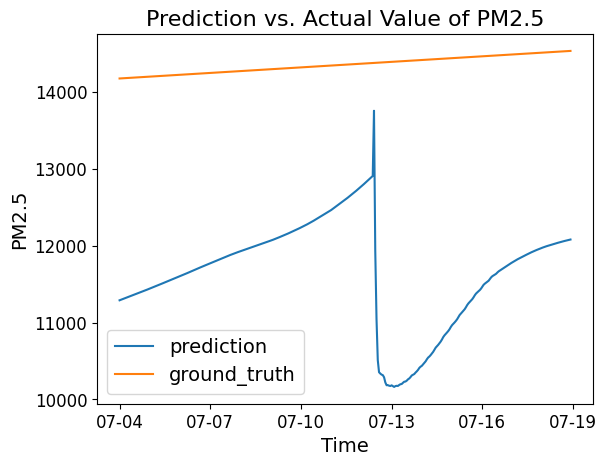

-----------------------------------------------------------------------------------------
| end of epoch 180 | time:  4.52s | valid loss 0.07249 | valid ppl     1.08
| end of epoch 180 | time:  4.52s | train loss 0.02268 | train ppl     1.02
-----------------------------------------------------------------------------------------
| epoch 181 |    10/   54 batches | lr 0.000013 | 11.76 ms | loss 0.07964 | ppl     1.08


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:381: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch 181 |    20/   54 batches | lr 0.000013 | 10.10 ms | loss 0.03237 | ppl     1.03
| epoch 181 |    30/   54 batches | lr 0.000013 | 10.06 ms | loss 0.03159 | ppl     1.03
| epoch 181 |    40/   54 batches | lr 0.000013 | 10.33 ms | loss 0.03030 | ppl     1.03
| epoch 181 |    50/   54 batches | lr 0.000013 | 10.38 ms | loss 0.04042 | ppl     1.04
-----------------------------------------------------------------------------------------
| end of epoch 181 | time:  0.86s | valid loss 0.07245 | valid ppl     1.08
| end of epoch 181 | time:  0.86s | train loss 0.02275 | train ppl     1.02
-----------------------------------------------------------------------------------------
| epoch 182 |    10/   54 batches | lr 0.000013 | 11.10 ms | loss 0.07846 | ppl     1.08
| epoch 182 |    20/   54 batches | lr 0.000013 | 10.00 ms | loss 0.03293 | ppl     1.03
| epoch 182 |    30/   54 batches | lr 0.000013 | 10.07 ms | loss 0.02975 | ppl     1.03
| epoch 182 |    40/   54 batches | lr 0.0000

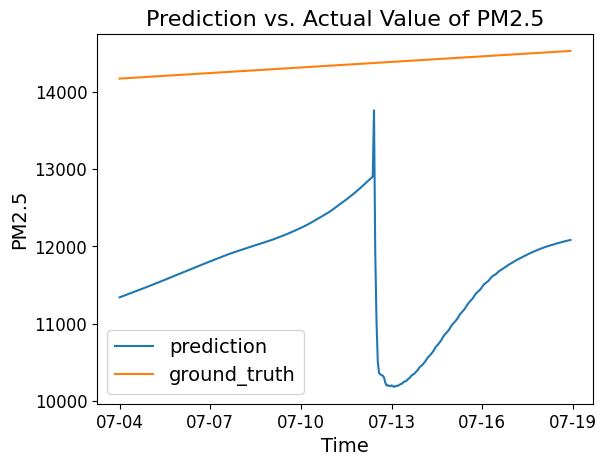

-----------------------------------------------------------------------------------------
| end of epoch 210 | time:  4.51s | valid loss 0.07141 | valid ppl     1.07
| end of epoch 210 | time:  4.51s | train loss 0.02251 | train ppl     1.02
-----------------------------------------------------------------------------------------
| epoch 211 |    10/   54 batches | lr 0.000007 | 11.83 ms | loss 0.07757 | ppl     1.08


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:381: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch 211 |    20/   54 batches | lr 0.000007 | 10.23 ms | loss 0.03581 | ppl     1.04
| epoch 211 |    30/   54 batches | lr 0.000007 | 10.17 ms | loss 0.03123 | ppl     1.03
| epoch 211 |    40/   54 batches | lr 0.000007 | 10.27 ms | loss 0.03128 | ppl     1.03
| epoch 211 |    50/   54 batches | lr 0.000007 | 10.08 ms | loss 0.03751 | ppl     1.04
-----------------------------------------------------------------------------------------
| end of epoch 211 | time:  0.86s | valid loss 0.07135 | valid ppl     1.07
| end of epoch 211 | time:  0.86s | train loss 0.02246 | train ppl     1.02
-----------------------------------------------------------------------------------------
| epoch 212 |    10/   54 batches | lr 0.000007 | 10.90 ms | loss 0.07621 | ppl     1.08
| epoch 212 |    20/   54 batches | lr 0.000007 | 10.33 ms | loss 0.03341 | ppl     1.03
| epoch 212 |    30/   54 batches | lr 0.000007 | 10.34 ms | loss 0.02937 | ppl     1.03
| epoch 212 |    40/   54 batches | lr 0.0000

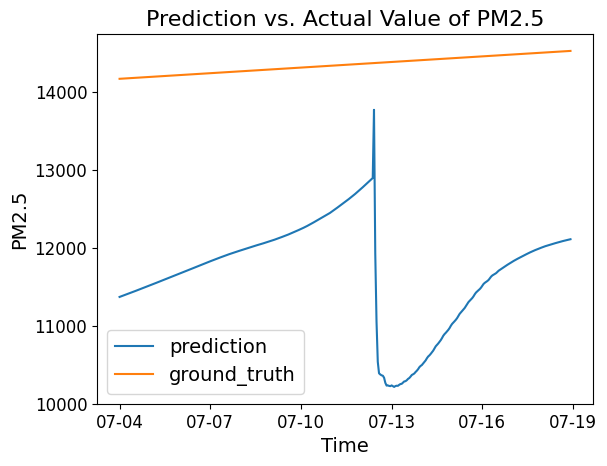

-----------------------------------------------------------------------------------------
| end of epoch 240 | time:  4.44s | valid loss 0.07078 | valid ppl     1.07
| end of epoch 240 | time:  4.44s | train loss 0.02231 | train ppl     1.02
-----------------------------------------------------------------------------------------
| epoch 241 |    10/   54 batches | lr 0.000004 | 11.61 ms | loss 0.07635 | ppl     1.08


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:381: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch 241 |    20/   54 batches | lr 0.000004 | 10.46 ms | loss 0.03477 | ppl     1.04
| epoch 241 |    30/   54 batches | lr 0.000004 | 10.16 ms | loss 0.02938 | ppl     1.03
| epoch 241 |    40/   54 batches | lr 0.000004 | 10.21 ms | loss 0.02856 | ppl     1.03
| epoch 241 |    50/   54 batches | lr 0.000004 | 10.93 ms | loss 0.03760 | ppl     1.04
-----------------------------------------------------------------------------------------
| end of epoch 241 | time:  0.86s | valid loss 0.07072 | valid ppl     1.07
| end of epoch 241 | time:  0.86s | train loss 0.02226 | train ppl     1.02
-----------------------------------------------------------------------------------------
| epoch 242 |    10/   54 batches | lr 0.000004 | 10.99 ms | loss 0.07441 | ppl     1.08
| epoch 242 |    20/   54 batches | lr 0.000004 |  9.89 ms | loss 0.03320 | ppl     1.03
| epoch 242 |    30/   54 batches | lr 0.000004 | 10.09 ms | loss 0.03173 | ppl     1.03
| epoch 242 |    40/   54 batches | lr 0.0000

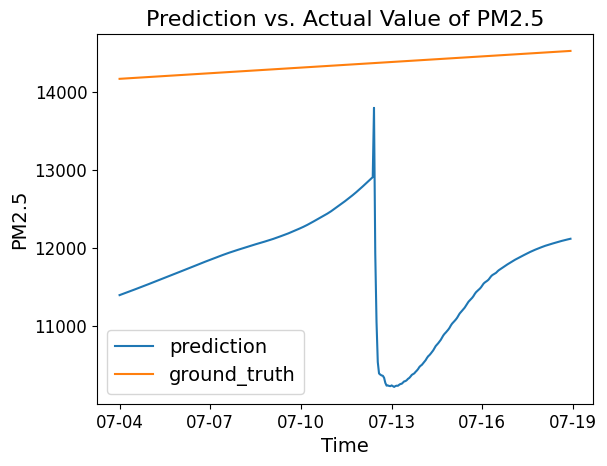

-----------------------------------------------------------------------------------------
| end of epoch 270 | time:  4.51s | valid loss 0.07044 | valid ppl     1.07
| end of epoch 270 | time:  4.51s | train loss 0.02219 | train ppl     1.02
-----------------------------------------------------------------------------------------
| epoch 271 |    10/   54 batches | lr 0.000002 | 11.46 ms | loss 0.07271 | ppl     1.08


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:381: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch 271 |    20/   54 batches | lr 0.000002 | 10.64 ms | loss 0.03303 | ppl     1.03
| epoch 271 |    30/   54 batches | lr 0.000002 | 10.25 ms | loss 0.02906 | ppl     1.03
| epoch 271 |    40/   54 batches | lr 0.000002 |  9.99 ms | loss 0.03096 | ppl     1.03
| epoch 271 |    50/   54 batches | lr 0.000002 | 10.27 ms | loss 0.03899 | ppl     1.04
-----------------------------------------------------------------------------------------
| end of epoch 271 | time:  0.86s | valid loss 0.07040 | valid ppl     1.07
| end of epoch 271 | time:  0.86s | train loss 0.02220 | train ppl     1.02
-----------------------------------------------------------------------------------------
| epoch 272 |    10/   54 batches | lr 0.000002 | 11.10 ms | loss 0.07680 | ppl     1.08
| epoch 272 |    20/   54 batches | lr 0.000002 | 10.22 ms | loss 0.03410 | ppl     1.03
| epoch 272 |    30/   54 batches | lr 0.000002 | 10.34 ms | loss 0.03046 | ppl     1.03
| epoch 272 |    40/   54 batches | lr 0.0000

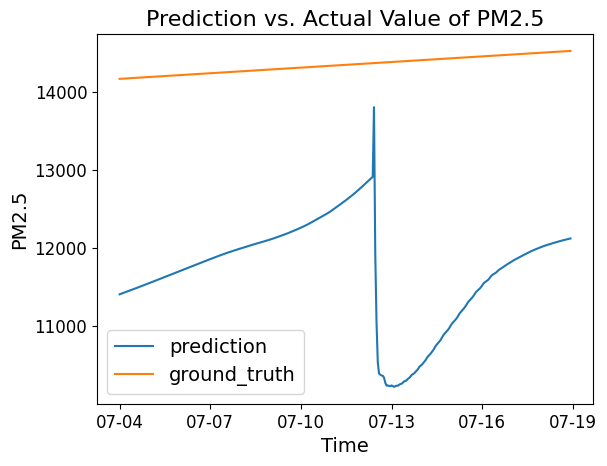

-----------------------------------------------------------------------------------------
| end of epoch 300 | time:  4.50s | valid loss 0.07026 | valid ppl     1.07
| end of epoch 300 | time:  4.50s | train loss 0.02217 | train ppl     1.02
-----------------------------------------------------------------------------------------
| epoch 301 |    10/   54 batches | lr 0.000001 | 11.76 ms | loss 0.07621 | ppl     1.08


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:381: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch 301 |    20/   54 batches | lr 0.000001 | 10.47 ms | loss 0.03546 | ppl     1.04
| epoch 301 |    30/   54 batches | lr 0.000001 | 10.25 ms | loss 0.02905 | ppl     1.03
| epoch 301 |    40/   54 batches | lr 0.000001 | 10.08 ms | loss 0.03035 | ppl     1.03
| epoch 301 |    50/   54 batches | lr 0.000001 | 10.39 ms | loss 0.03808 | ppl     1.04
-----------------------------------------------------------------------------------------
| end of epoch 301 | time:  0.86s | valid loss 0.07022 | valid ppl     1.07
| end of epoch 301 | time:  0.86s | train loss 0.02217 | train ppl     1.02
-----------------------------------------------------------------------------------------
| epoch 302 |    10/   54 batches | lr 0.000001 | 11.13 ms | loss 0.07524 | ppl     1.08
| epoch 302 |    20/   54 batches | lr 0.000001 | 10.22 ms | loss 0.03397 | ppl     1.03
| epoch 302 |    30/   54 batches | lr 0.000001 | 10.32 ms | loss 0.03027 | ppl     1.03
| epoch 302 |    40/   54 batches | lr 0.0000

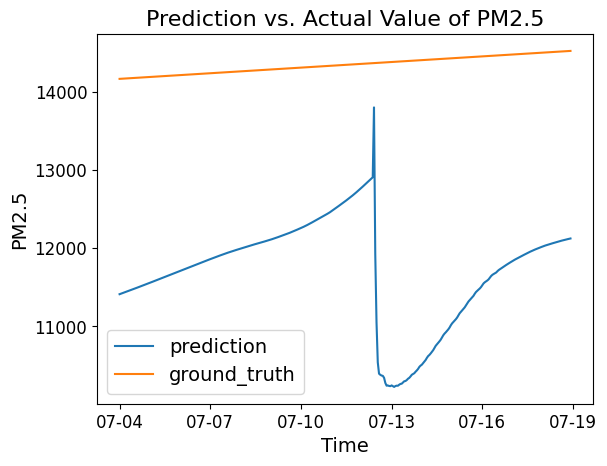

-----------------------------------------------------------------------------------------
| end of epoch 330 | time:  4.49s | valid loss 0.07017 | valid ppl     1.07
| end of epoch 330 | time:  4.49s | train loss 0.02212 | train ppl     1.02
-----------------------------------------------------------------------------------------
| epoch 331 |    10/   54 batches | lr 0.000001 | 12.72 ms | loss 0.07668 | ppl     1.08


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:381: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch 331 |    20/   54 batches | lr 0.000001 | 10.48 ms | loss 0.03305 | ppl     1.03
| epoch 331 |    30/   54 batches | lr 0.000001 | 10.50 ms | loss 0.03061 | ppl     1.03
| epoch 331 |    40/   54 batches | lr 0.000001 | 10.29 ms | loss 0.02990 | ppl     1.03
| epoch 331 |    50/   54 batches | lr 0.000001 | 10.25 ms | loss 0.03847 | ppl     1.04
-----------------------------------------------------------------------------------------
| end of epoch 331 | time:  0.87s | valid loss 0.07013 | valid ppl     1.07
| end of epoch 331 | time:  0.87s | train loss 0.02213 | train ppl     1.02
-----------------------------------------------------------------------------------------
| epoch 332 |    10/   54 batches | lr 0.000001 | 11.21 ms | loss 0.07540 | ppl     1.08
| epoch 332 |    20/   54 batches | lr 0.000001 |  9.99 ms | loss 0.03289 | ppl     1.03
| epoch 332 |    30/   54 batches | lr 0.000001 | 10.22 ms | loss 0.02900 | ppl     1.03
| epoch 332 |    40/   54 batches | lr 0.0000

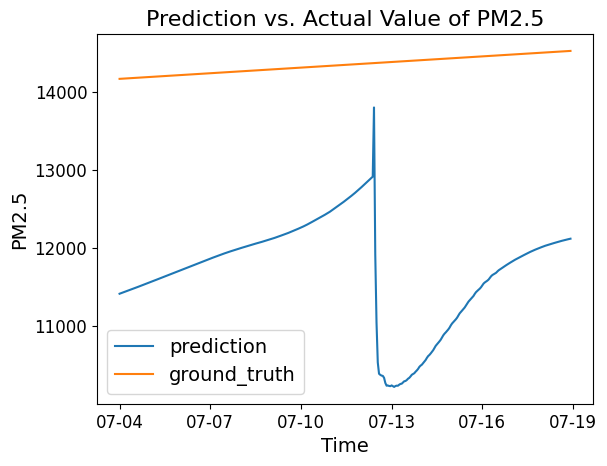

-----------------------------------------------------------------------------------------
| end of epoch 360 | time:  4.48s | valid loss 0.07015 | valid ppl     1.07
| end of epoch 360 | time:  4.48s | train loss 0.02217 | train ppl     1.02
-----------------------------------------------------------------------------------------
| epoch 361 |    10/   54 batches | lr 0.000000 | 11.71 ms | loss 0.07638 | ppl     1.08


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:381: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch 361 |    20/   54 batches | lr 0.000000 | 10.56 ms | loss 0.03338 | ppl     1.03
| epoch 361 |    30/   54 batches | lr 0.000000 | 10.10 ms | loss 0.03055 | ppl     1.03
| epoch 361 |    40/   54 batches | lr 0.000000 | 10.21 ms | loss 0.03085 | ppl     1.03
| epoch 361 |    50/   54 batches | lr 0.000000 | 10.19 ms | loss 0.03846 | ppl     1.04
-----------------------------------------------------------------------------------------
| end of epoch 361 | time:  0.86s | valid loss 0.07011 | valid ppl     1.07
| end of epoch 361 | time:  0.86s | train loss 0.02216 | train ppl     1.02
-----------------------------------------------------------------------------------------
| epoch 362 |    10/   54 batches | lr 0.000000 | 10.99 ms | loss 0.07465 | ppl     1.08
| epoch 362 |    20/   54 batches | lr 0.000000 | 10.30 ms | loss 0.03478 | ppl     1.04
| epoch 362 |    30/   54 batches | lr 0.000000 |  9.99 ms | loss 0.02995 | ppl     1.03
| epoch 362 |    40/   54 batches | lr 0.0000

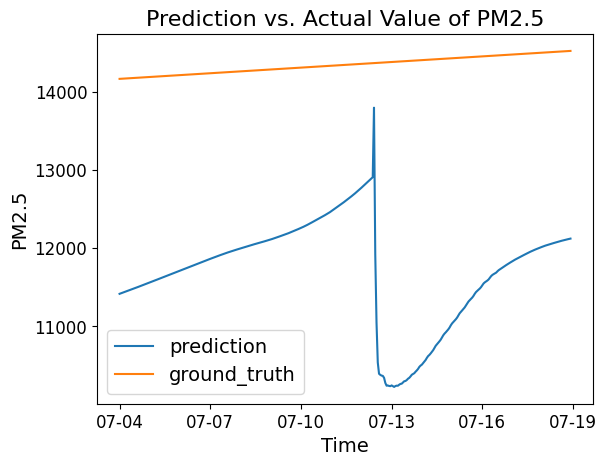

-----------------------------------------------------------------------------------------
| end of epoch 390 | time:  4.47s | valid loss 0.07011 | valid ppl     1.07
| end of epoch 390 | time:  4.47s | train loss 0.02214 | train ppl     1.02
-----------------------------------------------------------------------------------------
| epoch 391 |    10/   54 batches | lr 0.000000 | 11.26 ms | loss 0.07547 | ppl     1.08


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:381: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch 391 |    20/   54 batches | lr 0.000000 | 10.15 ms | loss 0.03326 | ppl     1.03
| epoch 391 |    30/   54 batches | lr 0.000000 | 10.06 ms | loss 0.03045 | ppl     1.03
| epoch 391 |    40/   54 batches | lr 0.000000 | 10.22 ms | loss 0.02945 | ppl     1.03
| epoch 391 |    50/   54 batches | lr 0.000000 | 10.27 ms | loss 0.03807 | ppl     1.04
-----------------------------------------------------------------------------------------
| end of epoch 391 | time:  0.85s | valid loss 0.07008 | valid ppl     1.07
| end of epoch 391 | time:  0.85s | train loss 0.02213 | train ppl     1.02
-----------------------------------------------------------------------------------------
| epoch 392 |    10/   54 batches | lr 0.000000 | 11.15 ms | loss 0.07785 | ppl     1.08
| epoch 392 |    20/   54 batches | lr 0.000000 | 10.01 ms | loss 0.03354 | ppl     1.03
| epoch 392 |    30/   54 batches | lr 0.000000 | 10.05 ms | loss 0.02957 | ppl     1.03
| epoch 392 |    40/   54 batches | lr 0.0000

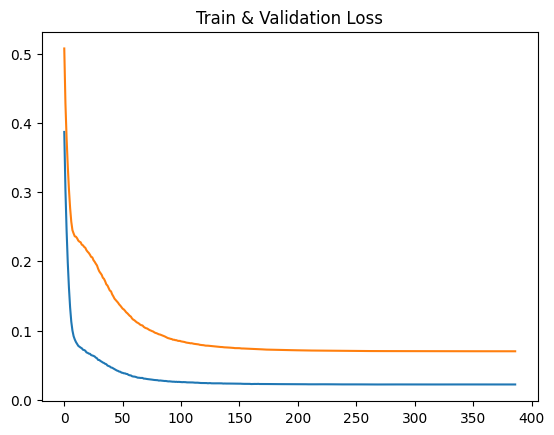

In [10]:
train_data, val_data, scaler  = get_data()
model = TransAm().to(device)

criterion = nn.MSELoss()
lr = 0.0005
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.98)

best_val_loss = float("inf")
epochs = 400
best_model = None

all_train_loss, all_val_loss = [], []

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(train_data)

    if epoch % 30 == 0:
        val_loss = plot(model, val_data, epoch, scaler)
        #predict_future(model, val_data, epoch, scaler)
    else:
        train_loss = evaluate(model, train_data)
        all_train_loss.append(train_loss)
        val_loss = evaluate(model, val_data)
        all_val_loss.append(val_loss)

    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.5f} | valid ppl {:8.2f}'.format(epoch, (
                time.time() - epoch_start_time), val_loss, math.exp(val_loss)))
    print('| end of epoch {:3d} | time: {:5.2f}s | train loss {:5.5f} | train ppl {:8.2f}'.format(epoch, (
                time.time() - epoch_start_time), train_loss, math.exp(train_loss)))
    print('-' * 89)

    # if val_loss < best_val_loss:
    #    best_val_loss = val_loss
    #    best_model = model

    scheduler.step()

pyplot.plot(all_train_loss)
pyplot.plot(all_val_loss)
pyplot.title('Train & Validation Loss')
pyplot.show()


# # calculate RMSE, MAE
# rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
# mae = mean_absolute_error(inv_y, inv_yhat)
# mape = mean_absolute_percentage_error(inv_y, inv_yhat)
# print('Test RMSE: %.3f' % rmse)
# print('Test MAE: %.3f' % mae)
# print('Test MAPE: %.3f' % mape)
#
# # src = torch.rand(input_window, batch_size, 1) # (source sequence length,batch size,feature number)
# # out = model(src)
# #
# # print(out)
# # print(out.shape)

In [ ]:
X = torch.Tensor(dataset.x)
X1 = torch.reshape(X, (X.shape[0], 1, X.shape[1]))
X1 = X1.to(device)

Y = torch.Tensor(dataset.y)

train_predict = model(X1)

train_predict = train_predict.to('cpu')
predicted = train_predict.data.numpy()
label_y = Y.data.numpy()

plt.figure(figsize=(10,6))
plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Voltage prediction')
plt.legend()
plt.show()